## Import

In [1]:
import time
import psutil
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, desc, lag, to_date, expr, abs
from pyspark.sql.functions import mean, stddev, col, abs
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.regression import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import PCA

## Pandas Settings

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Metric Function

In [3]:
process = psutil.Process()
def metrics_start():
    return {"time": time.time(), "mem": process.memory_info().rss, "cpu": psutil.cpu_percent(interval=None)}

def metrics_end(start, df=None):
    end_time = time.time()
    end_mem = process.memory_info().rss
    end_cpu = psutil.cpu_percent(interval=None)

    partitions = df.rdd.getNumPartitions() if df else None
    rows_per_partition = df.rdd.glom().map(len).collect() if df else None
    cores = psutil.cpu_count(logical=True)

    return {
        "time": end_time - start["time"],
        "mem_used_MB": (end_mem - start["mem"]) / (1024**2),
        "partitions": partitions,
        "rows_per_partition": rows_per_partition,
        "cores": cores
    }

## Pyspark Session

In [4]:
spark = SparkSession.builder \
    .appName("Tesla Deliveries") \
    .getOrCreate()

## Dataset

In [5]:
df = spark.read.csv("./datasets/tesla_deliveries_dataset_2015_2025.csv", header=True, inferSchema=True)
df.cache()
df.show(5)
df.printSchema()

+----+-----+-------------+-------+--------------------+----------------+-------------+--------------------+--------+--------------+--------------------+-----------------+
|Year|Month|       Region|  Model|Estimated_Deliveries|Production_Units|Avg_Price_USD|Battery_Capacity_kWh|Range_km|CO2_Saved_tons|         Source_Type|Charging_Stations|
+----+-----+-------------+-------+--------------------+----------------+-------------+--------------------+--------+--------------+--------------------+-----------------+
|2023|    5|       Europe|Model S|               17646|           17922|     92874.27|                 120|     704|       1863.42|Interpolated (Month)|            12207|
|2015|    2|         Asia|Model X|                3797|            4164|     62205.65|                  75|     438|        249.46|  Official (Quarter)|             7640|
|2019|    1|North America|Model X|                8411|            9189|    117887.32|                  82|     480|        605.59|Interpolated (

## Analytics

In [6]:
analytics_results = []

=== 1. Time-Series Analysis ===
+----------+------------------+------------------+
|Date      |Monthly_Deliveries|Rolling_12M_Avg   |
+----------+------------------+------------------+
|2015-01-01|183180            |183180.0          |
|2015-02-01|165053            |174116.5          |
|2015-03-01|184567            |177600.0          |
|2015-04-01|225623            |189605.75         |
|2015-05-01|184264            |188537.4          |
|2015-06-01|198787            |190245.66666666666|
|2015-07-01|177759            |188461.85714285713|
|2015-08-01|214223            |191682.0          |
|2015-09-01|188448            |191322.66666666666|
|2015-10-01|221541            |194344.5          |
|2015-11-01|211490            |195903.18181818182|
|2015-12-01|220332            |197938.91666666666|
|2016-01-01|191069            |198596.33333333334|
|2016-02-01|218600            |203058.58333333334|
|2016-03-01|191208            |203612.0          |
|2016-04-01|184134            |200154.58333333334|

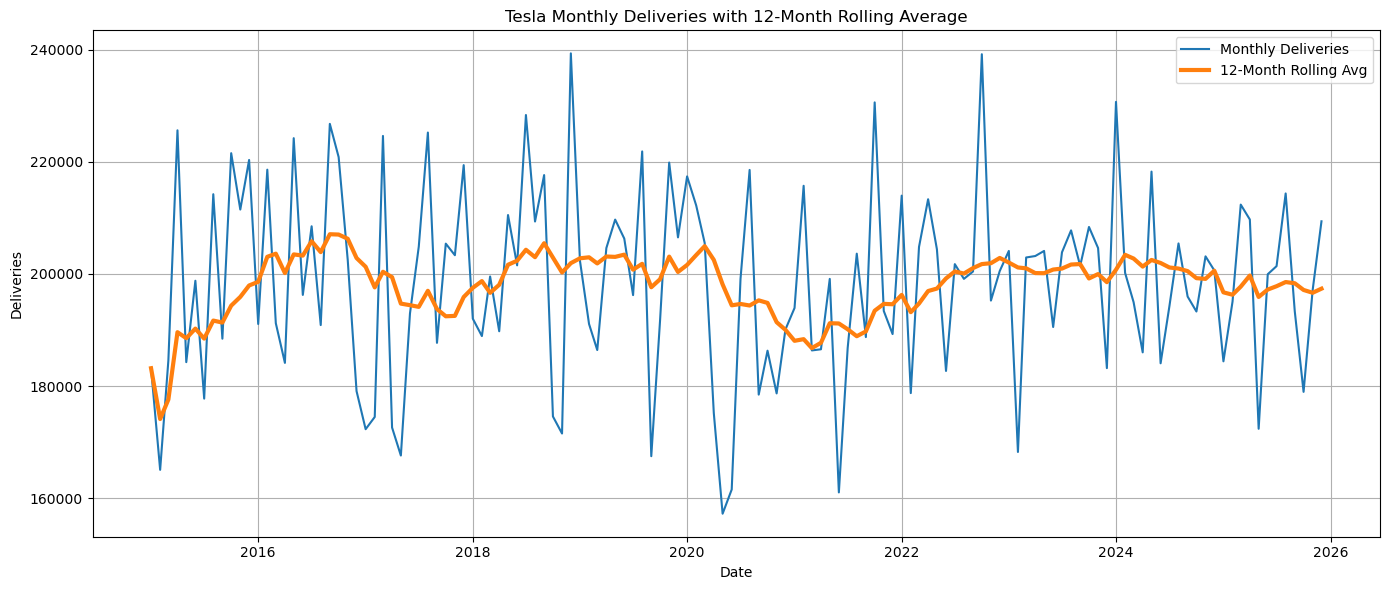

In [7]:
# 1. Time-Series: Year-Month + 12M Rolling Avg
print("=== 1. Time-Series Analysis ===")
start = metrics_start()
ts = df.withColumn("Date", to_date(expr("concat(Year,'-',Month,'-01')")))
window_12 = Window.orderBy("Date").rowsBetween(-11, 0)
ts = ts.groupBy("Date").agg(sum("Estimated_Deliveries").alias("Monthly_Deliveries")) \
       .repartition(4)
ts = ts.withColumn("Rolling_12M_Avg", avg("Monthly_Deliveries").over(window_12)).orderBy("Date")
ts_metrics = metrics_end(start, ts)
ts.show(20, False)
print("Metrics:", ts_metrics)
analytics_results.append(("Time-Series", ts_metrics))

ts_pdf = ts.toPandas().sort_values("Date")
plt.figure(figsize=(14, 6))
plt.plot(ts_pdf["Date"], ts_pdf["Monthly_Deliveries"], label="Monthly Deliveries")
plt.plot(ts_pdf["Date"], ts_pdf["Rolling_12M_Avg"], label="12-Month Rolling Avg", linewidth=3)

plt.title("Tesla Monthly Deliveries with 12-Month Rolling Average")
plt.xlabel("Date")
plt.ylabel("Deliveries")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

=== 2. Z-Score Anomaly Detection ===
+----+-----+-------------+-------+--------------------+----------------+-------------+--------------------+--------+--------------+--------------------+-----------------+------------------+
|Year|Month|       Region|  Model|Estimated_Deliveries|Production_Units|Avg_Price_USD|Battery_Capacity_kWh|Range_km|CO2_Saved_tons|         Source_Type|Charging_Stations|            Zscore|
+----+-----+-------------+-------+--------------------+----------------+-------------+--------------------+--------+--------------+--------------------+-----------------+------------------+
|2015|    3|         Asia|Model 3|               25410|           28802|     73659.66|                  60|     341|       1299.72|  Official (Quarter)|             4127|3.9349585269234173|
|2015|    6|  Middle East|Model Y|               22315|           22673|     81318.87|                  82|     472|        1579.9|Interpolated (Month)|             5909|  3.14861725553746|
|2022|    5| 

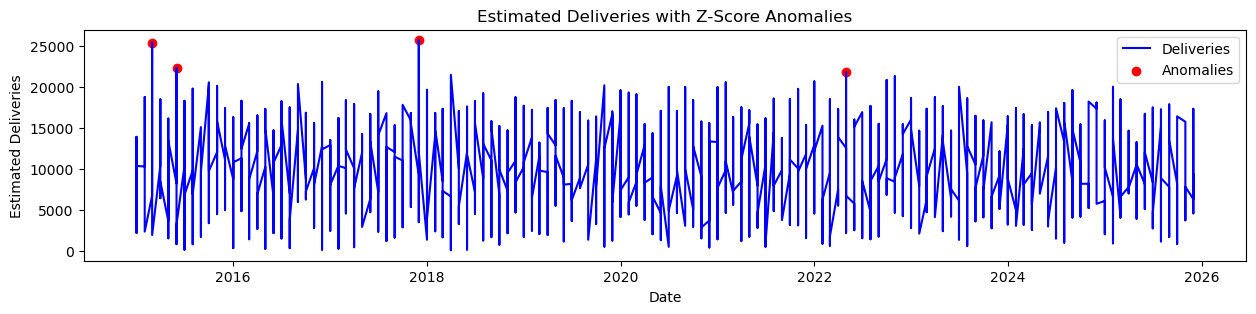

In [8]:
# 2. Z-Score Anomaly Detection
print("=== 2. Z-Score Anomaly Detection ===")
start = metrics_start()
stats = df.select(mean("Estimated_Deliveries").alias("mean_del"),
                  stddev("Estimated_Deliveries").alias("std_del")).collect()[0]
mean_del, std_del = stats
outliers = df.withColumn("Zscore", (col("Estimated_Deliveries") - mean_del)/std_del) \
             .filter(abs(col("Zscore")) > 3).repartition(4)
outliers_metrics = metrics_end(start, outliers)
outliers.show(10)
print("Metrics:", outliers_metrics)
analytics_results.append(("Z-Score Anomaly", outliers_metrics))


full_pdf = df.select("Year","Month","Estimated_Deliveries").toPandas()
full_pdf['Date'] = pd.to_datetime(full_pdf[['Year','Month']].assign(DAY=1))
full_pdf = full_pdf.sort_values("Date")
outlier_pdf = outliers.select("Year","Month","Estimated_Deliveries").toPandas()
outlier_pdf['Date'] = pd.to_datetime(outlier_pdf[['Year','Month']].assign(DAY=1))
plt.figure(figsize=(15,3))
plt.plot(full_pdf['Date'], full_pdf['Estimated_Deliveries'], color='blue', label='Deliveries')
plt.scatter(outlier_pdf['Date'], outlier_pdf['Estimated_Deliveries'], color='red', label='Anomalies')
plt.title("Estimated Deliveries with Z-Score Anomalies")
plt.xlabel("Date")
plt.ylabel("Estimated Deliveries")
plt.legend()
plt.grid(False)
plt.show()

In [9]:
# 3. Model-Level Z-Score
print("=== 3. Model Z-Score ===")
w = Window.partitionBy("Model")
start = metrics_start()
df_model_z = df.withColumn("mean_del", mean("Estimated_Deliveries").over(w)) \
               .withColumn("std_del", stddev("Estimated_Deliveries").over(w)) \
               .withColumn("Zscore", (col("Estimated_Deliveries") - col("mean_del")) / col("std_del")) \
               .filter(abs(col("Zscore")) > 3).repartition(4)
model_z_metrics = metrics_end(start, df_model_z)
df_model_z.show(10)
print("Metrics:", model_z_metrics)
analytics_results.append(("Model Z-Score", model_z_metrics))

=== 3. Model Z-Score ===
+----+-----+-------------+-------+--------------------+----------------+-------------+--------------------+--------+--------------+--------------------+-----------------+------------------+------------------+------------------+
|Year|Month|       Region|  Model|Estimated_Deliveries|Production_Units|Avg_Price_USD|Battery_Capacity_kWh|Range_km|CO2_Saved_tons|         Source_Type|Charging_Stations|          mean_del|           std_del|            Zscore|
+----+-----+-------------+-------+--------------------+----------------+-------------+--------------------+--------+--------------+--------------------+-----------------+------------------+------------------+------------------+
|2017|   12|North America|Model 3|               25704|           28939|     61247.57|                 120|     661|       2548.55|  Official (Quarter)|             8388|10079.392045454546|3880.1182237721755|  4.02683811509112|
|2015|    6|  Middle East|Model Y|               22315|        

=== 4. Supply Chain Stress Index ===
+----+----------+------+------+-------------------+
|Year|     Model|  Prod|   Del|       Stress_Index|
+----+----------+------+------+-------------------+
|2015|Cybertruck|461503|430202|0.07275884352002082|
|2015|   Model 3|566597|523716|0.08187834627928113|
|2015|   Model S|544677|510293|0.06738089685729572|
|2015|   Model X|466300|437366|0.06615511951089019|
|2015|   Model Y|506618|473690|0.06951381705334712|
|2016|Cybertruck|511311|475256|0.07586437625195684|
|2016|   Model 3|504713|467772| 0.0789722343363861|
|2016|   Model S|563981|523248| 0.0778464513958964|
|2016|   Model X|524056|485308|0.07984207966899372|
|2016|   Model Y|512939|482497|0.06309262026499647|
|2017|Cybertruck|526623|492785|0.06866686283064623|
|2017|   Model 3|510031|473837|0.07638491717615974|
|2017|   Model S|500070|464815|  0.075847380140486|
|2017|   Model X|470047|439791|0.06879631461307757|
|2017|   Model Y|520313|479289|0.08559345196739337|
|2018|Cybertruck|459831|426

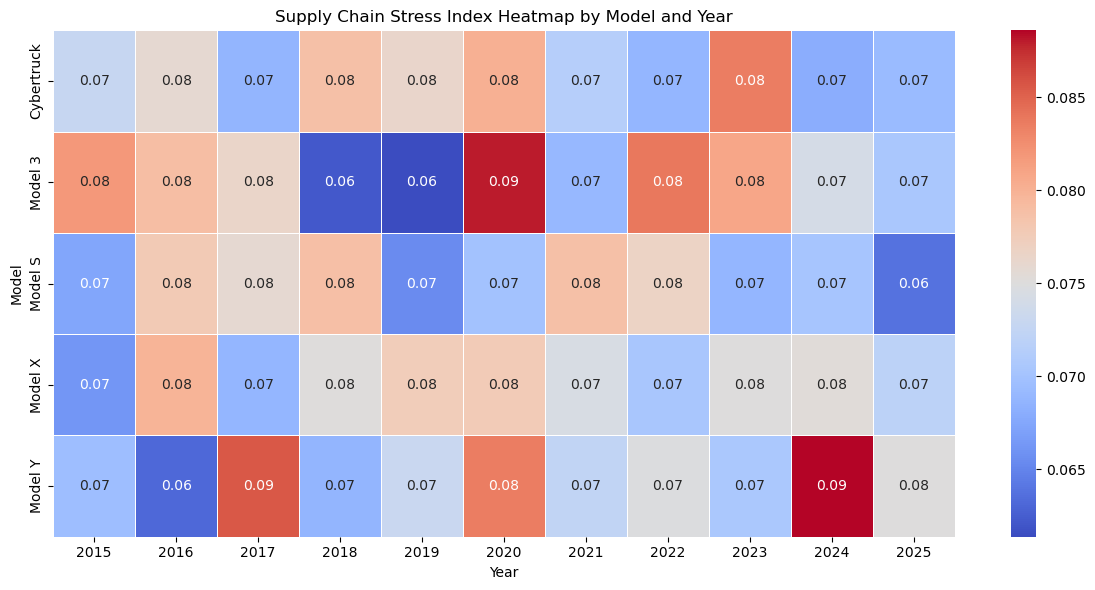

In [10]:
# 4. Supply Chain Stress Index
print("=== 4. Supply Chain Stress Index ===")
start = metrics_start()
supply_chain = df.groupBy("Year", "Model").agg(
    sum("Production_Units").alias("Prod"),
    sum("Estimated_Deliveries").alias("Del")
).withColumn(
    "Stress_Index", (col("Prod") - col("Del")) / col("Del")
).repartition(4) \
 .orderBy(col("Year").cast("int"), col("Model"))
supply_chain_metrics = metrics_end(start, supply_chain)
supply_chain.show(20)
print("Metrics:", supply_chain_metrics)
analytics_results.append(("Supply Chain Stress", supply_chain_metrics))


sc_pdf = supply_chain.select("Year","Model","Stress_Index").toPandas()
sc_pdf_pivot = sc_pdf.pivot(index="Model", columns="Year", values="Stress_Index")
plt.figure(figsize=(12,6))
sns.heatmap(sc_pdf_pivot, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title("Supply Chain Stress Index Heatmap by Model and Year")
plt.xlabel("Year")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

=== 5. CO2 Savings Intensity ===
+----------+-------------------+------------------+
|     Model|        CO2_per_Car|         Avg_Range|
+----------+-------------------+------------------+
|   Model 3|0.07569098853251986|503.22159090909093|
|   Model X|0.07522671235001668| 500.7765151515151|
|   Model Y|0.07437876103959128| 496.2386363636364|
|   Model S|0.07484062571730463| 501.2234848484849|
|Cybertruck| 0.0748091453661694| 499.8276515151515|
+----------+-------------------+------------------+

Metrics: {'time': 0.033208370208740234, 'mem_used_MB': 0.0, 'partitions': 4, 'rows_per_partition': [1, 2, 1, 1], 'cores': 14}


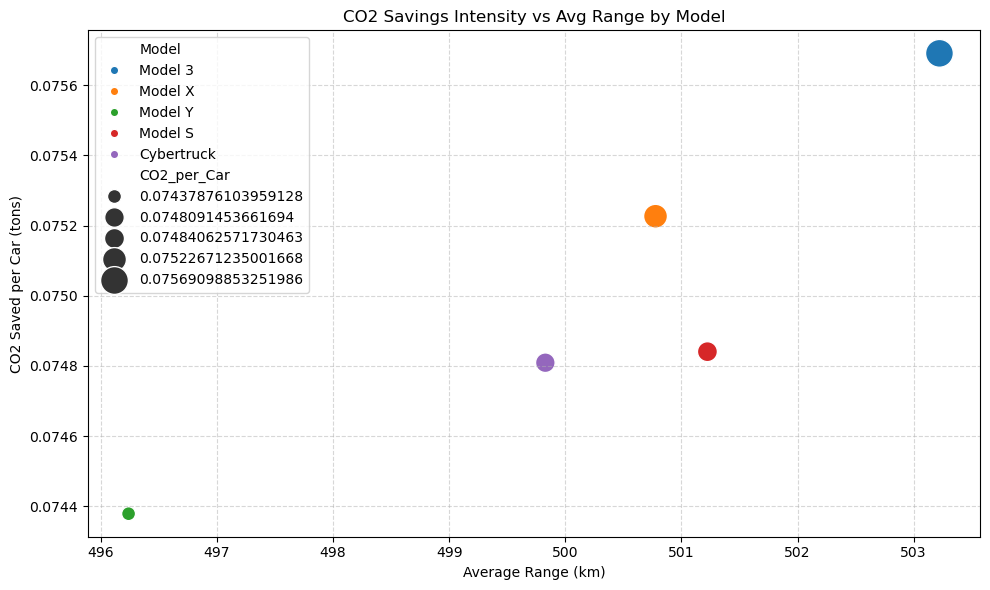

In [11]:
# 5. CO2 Savings Intensity
print("=== 5. CO2 Savings Intensity ===")
start = metrics_start()
env_index = df.groupBy("Model").agg(
    (sum("CO2_Saved_tons") / sum("Estimated_Deliveries")).alias("CO2_per_Car"),
    avg("Range_km").alias("Avg_Range")
).orderBy(desc("CO2_per_Car")).repartition(4)
env_index_metrics = metrics_end(start, env_index)
env_index.show(10)
print("Metrics:", env_index_metrics)
analytics_results.append(("CO2 Savings Intensity", env_index_metrics))


env_pdf = env_index.toPandas()
plt.figure(figsize=(10,6))
sns.scatterplot(data=env_pdf, x="Avg_Range", y="CO2_per_Car", size="CO2_per_Car",
                hue="Model", palette="tab10", sizes=(100, 400), legend="full")
plt.title("CO2 Savings Intensity vs Avg Range by Model")
plt.xlabel("Average Range (km)")
plt.ylabel("CO2 Saved per Car (tons)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

=== 6. Linear Regression Forecast ===
+----+--------+-----------------+
|Year|features|       prediction|
+----+--------+-----------------+
|2026|[2026.0]|2376197.309090884|
|2027|[2027.0]|2375342.209090879|
+----+--------+-----------------+

Metrics: {'time': 0.8969690799713135, 'mem_used_MB': 0.125, 'partitions': 14, 'rows_per_partition': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1], 'cores': 14}


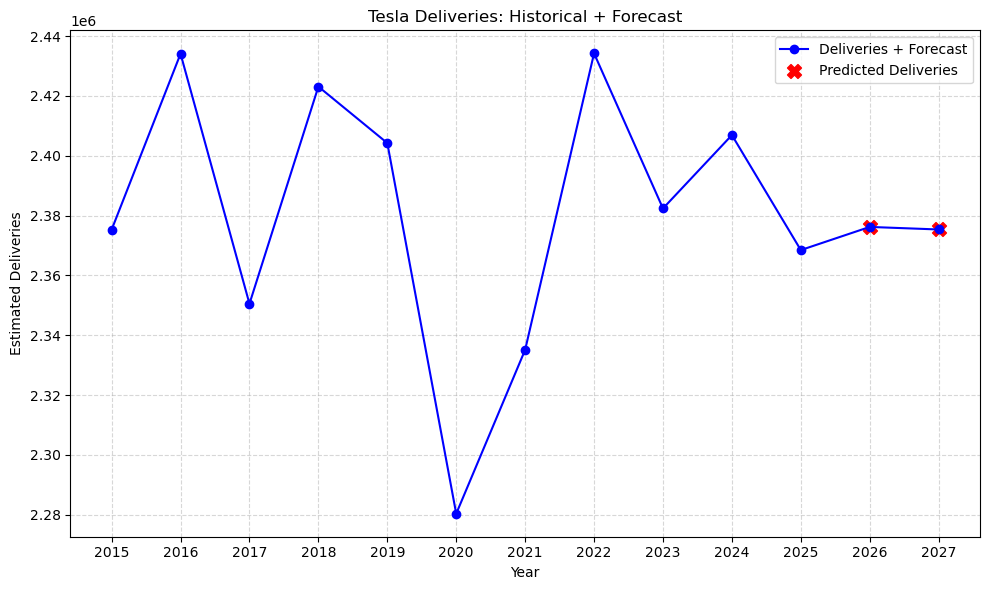

In [12]:
# 6. Linear Regression Forecast
print("=== 6. Linear Regression Forecast ===")
yearly = df.groupBy("Year").agg(sum("Estimated_Deliveries").alias("Deliveries")).repartition(4)
assembler = VectorAssembler(inputCols=["Year"], outputCol="features")
train_df = assembler.transform(yearly)
start = metrics_start()
lr = LinearRegression(featuresCol="features", labelCol="Deliveries")
model = lr.fit(train_df)
pred_df = spark.createDataFrame([(2026,), (2027,)], ["Year"])
pred = model.transform(assembler.transform(pred_df))
lr_metrics = metrics_end(start, pred)
pred.show()
print("Metrics:", lr_metrics)
analytics_results.append(("Linear Regression", lr_metrics))


history_pdf = yearly.toPandas().sort_values("Year")
pred_pdf = pred.select("Year", "prediction").toPandas()
combined_pdf = pd.concat([
    history_pdf.rename(columns={"Deliveries":"Forecast"}),
    pred_pdf.rename(columns={"prediction":"Forecast"})
], ignore_index=True).sort_values("Year")
plt.figure(figsize=(10,6))
plt.plot(combined_pdf["Year"], combined_pdf["Forecast"], marker='o', color='blue', label="Deliveries + Forecast")
plt.scatter(pred_pdf["Year"], pred_pdf["prediction"], color='red', marker='X', s=100, label="Predicted Deliveries")

plt.title("Tesla Deliveries: Historical + Forecast")
plt.xlabel("Year")
plt.ylabel("Estimated Deliveries")
plt.xticks(list(history_pdf["Year"]) + list(pred_pdf["Year"]))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

=== 7. Price Elasticity Correlation ===
Price–Demand Correlation: -0.02754583970952005
Metrics: {'time': 0.12717866897583008, 'mem_used_MB': 0.0, 'partitions': 1, 'rows_per_partition': [2640], 'cores': 14}


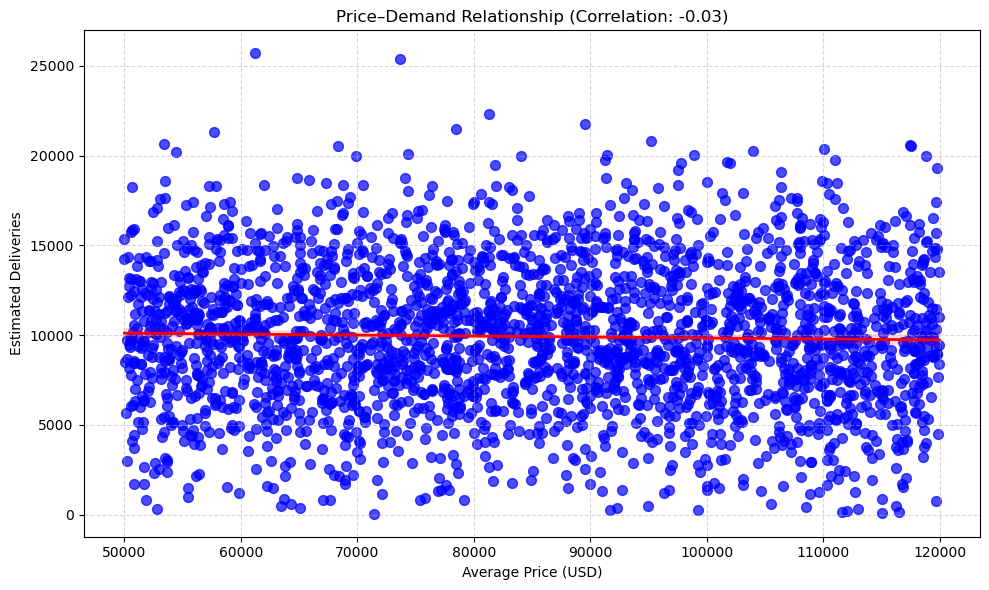

In [13]:
# 7. Price Elasticity Correlation
print("=== 7. Price Elasticity Correlation ===")
start = metrics_start()
elasticity = df.stat.corr("Avg_Price_USD", "Estimated_Deliveries")
elasticity_metrics = metrics_end(start, df)
print("Price–Demand Correlation:", elasticity)
print("Metrics:", elasticity_metrics)
analytics_results.append(("Price Elasticity Correlation", elasticity_metrics))


price_pdf = df.select("Avg_Price_USD", "Estimated_Deliveries").toPandas()
plt.figure(figsize=(10,6))
sns.regplot(x="Avg_Price_USD", y="Estimated_Deliveries", data=price_pdf,
            scatter_kws={'s':50, 'alpha':0.7, 'color':'blue'},
            line_kws={'color':'red', 'linewidth':2})

plt.title(f"Price–Demand Relationship (Correlation: {elasticity:.2f})")
plt.xlabel("Average Price (USD)")
plt.ylabel("Estimated Deliveries")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

=== 8. K-Means Clustering ===
+----------+-----+
|prediction|count|
+----------+-----+
|         1|  675|
|         3|  953|
|         2|  436|
|         0|  576|
+----------+-----+

Metrics: {'time': 2.0483157634735107, 'mem_used_MB': 0.0, 'partitions': 4, 'rows_per_partition': [660, 660, 660, 660], 'cores': 14}


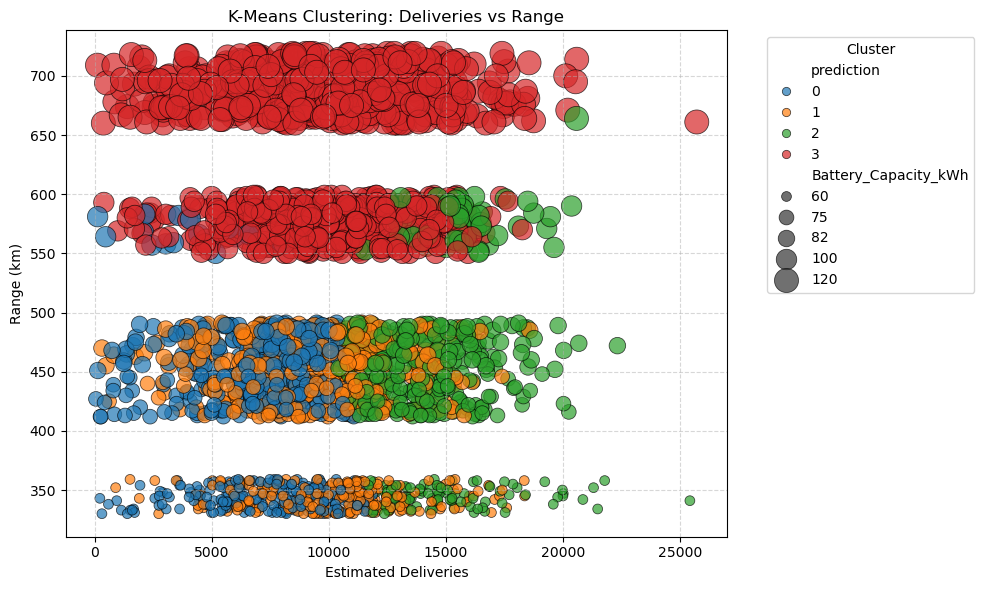

In [14]:
# 8. K-Means Clustering
print("=== 8. K-Means Clustering ===")
vec = VectorAssembler(inputCols=["Estimated_Deliveries", "Battery_Capacity_kWh", "Range_km", "Avg_Price_USD"],
                      outputCol="features_raw").transform(df)
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
scaled = scaler.fit(vec).transform(vec).repartition(4)
start = metrics_start()
kmeans = KMeans(k=4, seed=42)
km_model = kmeans.fit(scaled)
clusters = km_model.transform(scaled)
clusters_metrics = metrics_end(start, clusters)
clusters.groupBy("prediction").count().show()
print("Metrics:", clusters_metrics)
analytics_results.append(("K-Means Clustering", clusters_metrics))


viz_df = clusters.select("Estimated_Deliveries", "Range_km", "Avg_Price_USD", "Battery_Capacity_kWh", "prediction").toPandas()
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="Estimated_Deliveries",
    y="Range_km",
    hue="prediction",
    size="Battery_Capacity_kWh",
    data=viz_df,
    palette="tab10",
    sizes=(50, 300),
    alpha=0.7,
    edgecolor='k'
)
plt.title("K-Means Clustering: Deliveries vs Range")
plt.xlabel("Estimated Deliveries")
plt.ylabel("Range (km)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc=2)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


=== 9. Regional Performance Index ===
+-------------+----------+------------------+------------------+------------------+
|       Region|Deliveries|               CO2|         Avg_Range|             Score|
+-------------+----------+------------------+------------------+------------------+
|  Middle East|   6698045|503797.13999999984| 502.5439393939394| 3500262.150787879|
|North America|   6462592| 491073.0599999999|503.32575757575756| 3378718.583151515|
|         Asia|   6539935|         484357.26|495.49848484848485|3415373.7776969695|
|       Europe|   6494035|485135.78999999916|499.66212121212124|3392658.1694242423|
+-------------+----------+------------------+------------------+------------------+

Metrics: {'time': 0.03997087478637695, 'mem_used_MB': 0.0, 'partitions': 4, 'rows_per_partition': [1, 1, 1, 1], 'cores': 14}


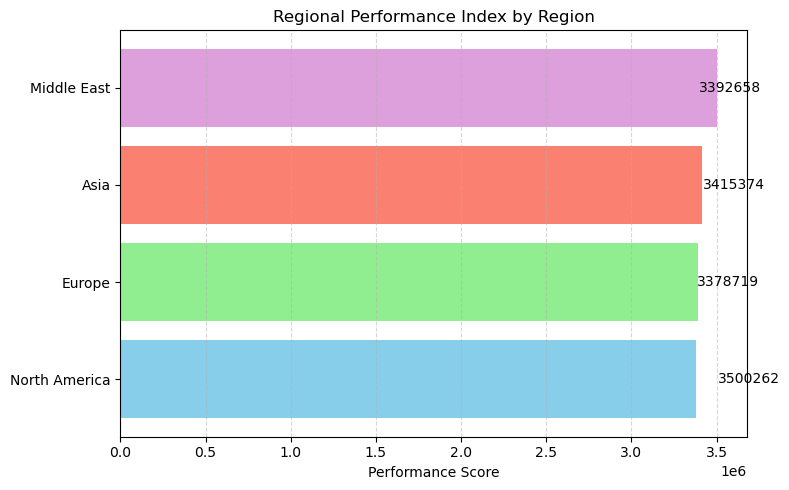

In [15]:
# 9. Regional Performance Index
print("=== 9. Regional Performance Index ===")
start = metrics_start()
region_perf = df.groupBy("Region").agg(
    sum("Estimated_Deliveries").alias("Deliveries"),
    sum("CO2_Saved_tons").alias("CO2"),
    avg("Range_km").alias("Avg_Range")
).withColumn("Score", col("Deliveries")*0.5 + col("CO2")*0.3 + col("Avg_Range")*0.2).orderBy(desc("Score")).repartition(4)
region_perf_metrics = metrics_end(start, region_perf)
region_perf.show(20)
print("Metrics:", region_perf_metrics)
analytics_results.append(("Regional Performance", region_perf_metrics))


region_pdf = region_perf.toPandas().sort_values("Score", ascending=True)
colors = ['skyblue', 'lightgreen', 'salmon', 'plum']  # one color per region
plt.figure(figsize=(8,5))
plt.barh(region_pdf['Region'], region_pdf['Score'], color=colors)
for index, row in region_pdf.iterrows():
    plt.text(row["Score"] + 5000, index, f'{row["Score"]:.0f}', va='center')
plt.xlabel("Performance Score")
plt.title("Regional Performance Index by Region")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

=== 10. Model Lifecycle Analysis ===
+----------+----+------+------+--------------+---------------+
|     Model|Year|   Del|  Prod|YoY_Del_Growth|YoY_Prod_Growth|
+----------+----+------+------+--------------+---------------+
|Cybertruck|2015|430202|461503|          NULL|           NULL|
|Cybertruck|2016|475256|511311|        0.1047|         0.1079|
|Cybertruck|2017|492785|526623|        0.0369|         0.0299|
|Cybertruck|2018|426255|459831|        -0.135|        -0.1268|
|Cybertruck|2019|461653|496903|         0.083|         0.0806|
|Cybertruck|2020|467716|505209|        0.0131|         0.0167|
|Cybertruck|2021|481289|515640|         0.029|         0.0206|
|Cybertruck|2022|436080|466058|       -0.0939|        -0.0962|
|Cybertruck|2023|454379|492338|         0.042|         0.0564|
|Cybertruck|2024|512794|547690|        0.1286|         0.1124|
|Cybertruck|2025|471370|503965|       -0.0808|        -0.0798|
|   Model 3|2015|523716|566597|          NULL|           NULL|
|   Model 3|2016|4

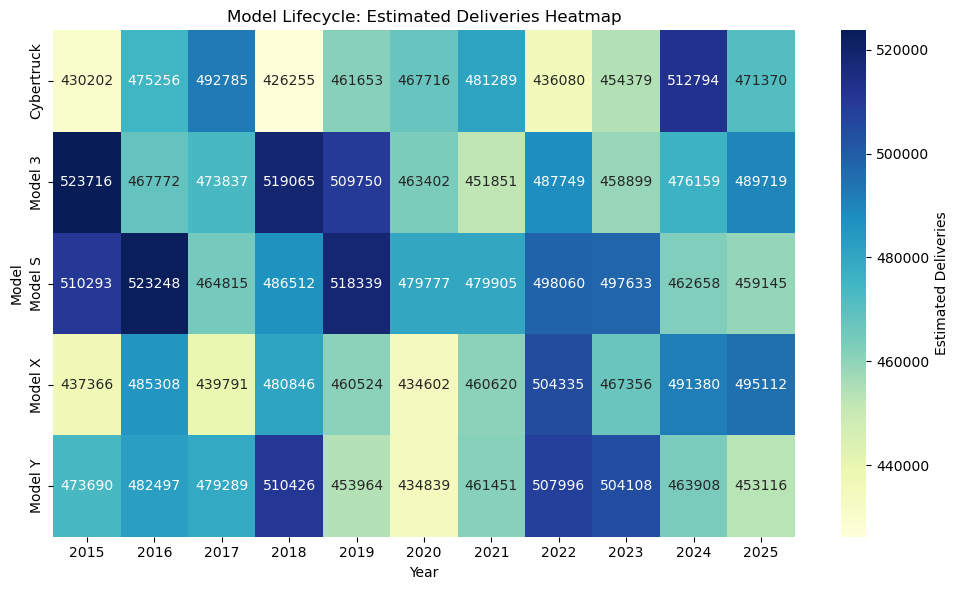

In [16]:
# 10. Model Lifecycle Analysis
print("=== 10. Model Lifecycle Analysis ===")
w = Window.partitionBy("Model").orderBy(F.col("Year").cast("int"))
start = metrics_start()
lifecycle = (
    df.groupBy("Model", "Year")
      .agg(
          F.sum("Estimated_Deliveries").alias("Del"),
          F.sum("Production_Units").alias("Prod")
      )
      .withColumn("YoY_Del_Growth",
                  (F.col("Del") - F.lag("Del").over(w)) / F.lag("Del").over(w))
      .withColumn("YoY_Prod_Growth",
                  (F.col("Prod") - F.lag("Prod").over(w)) / F.lag("Prod").over(w))
      .withColumn("YoY_Del_Growth", F.round(F.col("YoY_Del_Growth"), 4))
      .withColumn("YoY_Prod_Growth", F.round(F.col("YoY_Prod_Growth"), 4))
      .repartition(4)   # repartition BEFORE sorting
      .orderBy("Model", F.col("Year").cast("int"))
)
lifecycle_metrics = metrics_end(start, lifecycle)
lifecycle.show(20)
print("Metrics:", lifecycle_metrics)
analytics_results.append(("Model Lifecycle", lifecycle_metrics))


lifecycle_pdf = lifecycle.toPandas()
pivot_df = lifecycle_pdf.pivot(index='Model', columns='Year', values='Del')

plt.figure(figsize=(10,6))
sns.heatmap(pivot_df, annot=True, fmt='g', cmap='YlGnBu', cbar_kws={'label': 'Estimated Deliveries'})
plt.title("Model Lifecycle: Estimated Deliveries Heatmap")
plt.xlabel("Year")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

## Metrics

In [17]:
summary_df = pd.DataFrame([{"analytics": a[0], **a[1]} for a in analytics_results])
summary_df.to_csv("./results/pyspark_summary.csv", index=False)
print("\n=== PySpark Analytics Summary ===")
summary_df


=== PySpark Analytics Summary ===


,analytics,time,mem_used_MB,partitions,rows_per_partition,cores
0,Time-Series,0.159724,0.000,1,[132],14
1,Z-Score Anomaly,0.226346,0.000,4,"[1, 1, 1, 1]",14
2,Model Z-Score,0.075795,0.000,4,"[1, 1, 1, 1]",14
3,Supply Chain Stress,0.051571,0.000,1,[55],14
4,CO2 Savings Intensity,0.033208,0.000,4,"[1, 2, 1, 1]",14
5,Linear Regression,0.896969,0.125,14,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]",14
6,Price Elasticity Correlation,0.127179,0.000,1,[2640],14
7,K-Means Clustering,2.048316,0.000,4,"[660, 660, 660, 660]",14
8,Regional Performance,0.039971,0.000,4,"[1, 1, 1, 1]",14
9,Model Lifecycle,0.074049,0.000,1,[55],14
